# Word Embedding - Home Assigment
## Dr. Omri Allouche 2021. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/ydata_deep_learning_2021/blob/master/assignments/word_vectors_text_classification/DL_word_embedding_assignment.ipynb)

    
In this exercise, you'll use word vectors trained on a corpus of lyrics of songs from MetroLyrics ([http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet](/data/metrolyrics.parquet)).
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [ ]:
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# nltk.FreqDist

df = pd.read_parquet("https://raw.githubusercontent.com/omriallouche/ydata_deep_learning_2021/master/data/metrolyrics.parquet")
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
all_words_list = set()

def process_text(text):

  text = word_tokenize(re.sub("[^A-Za-z']+", ' ', str(text.lower()))) # lowercasing and tokenization
  text = [word.translate(str.maketrans('', '', string.punctuation)).strip() for word in text] # remove punctuation
  text = [word for word in text if word not in stopwords.words('english') and word is not ''] # remove stopwords

  all_words_list.update(set(text))

  return ' '.join(text)


df['clean_lyrics'] = df.apply(lambda x: process_text(x['lyrics']), axis=1)

In [ ]:
sent = [row.split() for row in df['clean_lyrics']]

In [ ]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(sent, min_count=30, progress_per=10000)

In [ ]:
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
from time import time
import multiprocessing

cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.45 mins


In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 28.34 mins


In [ ]:
w2v_model.save('w2v_model.model')

In [ ]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load("w2v_model.model")

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
import pandas as pd
df_link = 'https://drive.google.com/file/d/1rizUS3P236UO00eoShbB_3BoYyQcmaUA/view?usp=sharing' # The shareable link
id = df_link.split('/')[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('metrolyrics.csv')  
df = pd.read_csv('metrolyrics.csv')
df.head()

,Unnamed: 0,song,year,artist,genre,lyrics,num_chars,sent,num_words,clean_lyrics
0,204182,fully-dressed,2008,annie,Pop,[HEALY]\n[spoken] This is Bert Healy saying .....,1041,healy spoken this bert healy saying singing he...,826,healy spoken bert healy saying singing hey hob...
1,6116,surrounded-by-hoes,2006,50-cent,Hip-Hop,[Chorus: repeat 2X] Even when I'm tryin to be ...,1392,chorus repeat x even i tryin low i recognized ...,884,chorus repeat 2x even tryin low recognized hoe...
2,166369,taste-the-tears-thunderpuss-remix,2006,amber,Pop,How could you cause me so much pain?\nAnd leav...,1113,how could cause much pain and leave heart rain...,756,could cause much pain leave heart rain gave ev...
3,198416,the-truth-will-set-me-free,2006,glenn-hughes,Rock,In a scarlet vision\nIn a velvet room\nI come ...,779,in scarlet vision in velvet room i come decisi...,583,scarlet vision velvet room come decision dog d...
4,127800,the-last-goodbye,2008,aaron-pritchett,Country,Sprintime in Savannah\nIt dont get much pretti...,881,sprintime savannah it dont get much prettier b...,639,sprintime savannah dont get much prettier feel...


In [4]:
from gensim.models import KeyedVectors

wv_link = 'https://drive.google.com/file/d/15hJufdgDnDunbUodZLo2REz1zJQ8Toyt/view?usp=sharing' # The shareable link
id = wv_link.split('/')[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('w2v_model.model') 

w2v_model = KeyedVectors.load("w2v_model.model")
w2v_model

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [4]:
print(w2v_model.wv.most_similar('mother',topn=3))
print(w2v_model.wv.most_similar('joke',topn=3))
print(w2v_model.wv.most_similar('stop',topn=3))

[('father', 0.48190930485725403), ('brother', 0.41736847162246704), ('child', 0.39826399087905884)]
[('broke', 0.36072659492492676), ('funny', 0.3560766279697418), ('comedian', 0.2867908179759979)]
[('cause', 0.5850833058357239), ('keep', 0.5623694658279419), ('know', 0.5231946110725403)]


### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [5]:
print(w2v_model.wv.most_similar(positive=["mother", "man"], negative=["woman"], topn=3))
print(w2v_model.wv.most_similar(positive=["father", "woman"], negative=["man"], topn=3))
print(w2v_model.wv.most_similar(positive=["king", "woman"], negative=["man"], topn=3))

[('brother', 0.4154040217399597), ('fuck', 0.39607614278793335), ('shit', 0.3740338385105133)]
[('mother', 0.34044840931892395), ('father_father', 0.33039313554763794), ('grace', 0.3256756365299225)]
[('queen', 0.3891682028770447), ('martin_luther', 0.3173820376396179), ('princess', 0.3081028163433075)]


## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [6]:
# get data
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

download_url = 'http://saifmohammad.com/WebDocs/lexiconstoreleaseonsclpage/SemEval2015-English-Twitter-Lexicon.zip'

sentiments_list = []

resp = urlopen(download_url)
zipfile = ZipFile(BytesIO(resp.read()))
file_name = zipfile.namelist()[-1]

negators = zipfile.namelist()[-2]
negators = zipfile.open(negators).readlines()
negators = [line.decode('utf-8').split()[0] for line in negators]

for line in zipfile.open(file_name).readlines():
  line = line.decode('utf-8').replace('#','').split()
  score = float(line[0])
  text = ' '.join(line[1:]).strip()
  word_a = text.split()[0]
  word_b = text.split()[1] if len(line) > 2 else None
  
  sentiments_list.append({'score': score,
                          'text':text,
                          'word_a':word_a,
                          'word_b':word_b})

In [7]:
# parse data
sentiment_df = pd.DataFrame(sentiments_list)
sentiment_df['words_for_train'] = sentiment_df.apply(lambda x: x['word_b'] if x['word_b'] else x['word_a'],axis=1)
sentiment_df['isin_vocab'] = sentiment_df.apply(lambda x: x['words_for_train'] in w2v_model.wv.vocab.keys(),axis=1)
sentiment_df = sentiment_df[sentiment_df['isin_vocab']]
sentiment_df['has_negators'] = sentiment_df.apply(lambda x: x['word_a'] in negators if x['word_b'] else False,axis=1)

sentiment_df['word_v'] = sentiment_df.apply(lambda x: w2v_model.wv.get_vector(x['words_for_train']),axis=1)
sentiment_df.head()

,score,text,word_a,word_b,words_for_train,isin_vocab,has_negators,word_v
0,0.984,loves,loves,None,loves,True,False,"[0.039917566, -0.19262722, -1.5087744, -0.6006..."
2,0.969,amazing,amazing,None,amazing,True,False,"[-1.1648709, -0.28753403, -0.4908852, -0.99061..."
3,0.969,peaceful,peaceful,None,peaceful,True,False,"[-0.023836747, -0.476886, -0.22323118, -1.2462..."
4,0.953,greatness,greatness,None,greatness,True,False,"[1.0555886, -1.1125934, -0.05948353, -1.023635..."
5,0.938,fantastic,fantastic,None,fantastic,True,False,"[-0.29725134, 0.38916177, -0.21154138, 1.04324..."


In [8]:
#train model
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(sentiment_df['word_v'].apply(pd.Series), 
                                                    sentiment_df['score'], 
                                                    test_size=0.33, 
                                                    random_state=42)

clf = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
                       learning_rate = 0.1,
                       max_depth = 5,
                       alpha = 10,
                       n_estimators = 10)

clf.fit(X_train,y_train)
preds = clf.predict(X_test)

preds_df = pd.DataFrame(zip(preds, y_test, y_test.index),columns=['preds','actual','index'])
preds_df = preds_df.merge(sentiment_df['has_negators'],left_on=['index'],right_index=True,how='left')
preds_df.loc[preds_df["has_negators"], "preds"] *=-1.0

preds_df.head()

[06:24:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,preds,actual,index,has_negators
0,0.201677,0.266,493,False
1,0.059057,-0.172,937,False
2,0.324986,0.172,601,False
3,-0.194144,-0.328,1068,True
4,0.266613,0.406,380,False


correlation - 0.40406202516304757
mean_absolute_error - 0.347034812262564
mean_squared_error - 0.19082109532488103


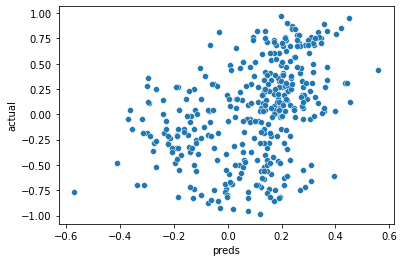

In [9]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import seaborn as sns

sns.scatterplot(data=preds_df,x='preds',y='actual');
print('correlation - %s' % preds_df[['preds','actual']].corr().loc['actual','preds']);
print('mean_absolute_error - %s' % mean_absolute_error(preds_df['preds'],preds_df['actual']))
print('mean_squared_error - %s' % mean_squared_error(preds_df['preds'],preds_df['actual']))

Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [10]:
song_a = df['clean_lyrics'][1].split()
song_a_words = pd.DataFrame([word for word in song_a if word in w2v_model.wv.vocab.keys()],columns=['word'])
song_a_vec = pd.DataFrame([w2v_model.wv.get_vector(word) for word in song_a if word in w2v_model.wv.vocab.keys()])

song_a_pred = pd.DataFrame(clf.predict(song_a_vec),columns=['pred_sentiment'])
pd.concat([song_a_words,song_a_pred],axis=1).drop_duplicates('pred_sentiment').sort_values(by=['pred_sentiment'],ascending=False)

,word,pred_sentiment
34,hits,0.417284
87,feelings,0.372209
66,dance,0.370345
39,ai,0.366835
97,yeah,0.362437
...,...,...
64,punk,-0.007750
132,mean,-0.008551
65,ass,-0.037825
58,nigga,-0.083347


### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['clean_lyrics'])
bow_df = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

remove_list = [word for word in vectorizer.get_feature_names() if word not in w2v_model.wv.vocab.keys()]
bow_df = bow_df.drop(remove_list,axis=1)
df=pd.concat([df,bow_df],axis=1)
df.head()

,Unnamed: 0,song,year,artist,genre,lyrics,num_chars,sent,num_words,clean_lyrics,10,100,12,20,2x,30,40,4x,50,aah,aber,able,accept,ace,aching,across,act,actin,acting,action,add,addicted,admit,adore,advice,affair,afford,afraid,age,ago,...,wow,wrap,wrapped,wrath,wreck,wrist,write,writing,written,wrong,wrote,x2,x3,x4,ya,yah,yall,yard,ye,yea,yeah,year,years,yellow,yes,yesterday,yet,yo,youll,young,younger,youre,youth,yuh,yup,zeit,zero,zone,zu,zum
0,204182,fully-dressed,2008,annie,Pop,[HEALY]\n[spoken] This is Bert Healy saying .....,1041,healy spoken this bert healy saying singing he...,826,healy spoken bert healy saying singing hey hob...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6116,surrounded-by-hoes,2006,50-cent,Hip-Hop,[Chorus: repeat 2X] Even when I'm tryin to be ...,1392,chorus repeat x even i tryin low i recognized ...,884,chorus repeat 2x even tryin low recognized hoe...,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,166369,taste-the-tears-thunderpuss-remix,2006,amber,Pop,How could you cause me so much pain?\nAnd leav...,1113,how could cause much pain and leave heart rain...,756,could cause much pain leave heart rain gave ev...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,198416,the-truth-will-set-me-free,2006,glenn-hughes,Rock,In a scarlet vision\nIn a velvet room\nI come ...,779,in scarlet vision in velvet room i come decisi...,583,scarlet vision velvet room come decision dog d...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,127800,the-last-goodbye,2008,aaron-pritchett,Country,Sprintime in Savannah\nIt dont get much pretti...,881,sprintime savannah it dont get much prettier b...,639,sprintime savannah dont get much prettier feel...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
ganre_df_list = []
top_ganre_words = {}
genre_df = df.groupby('genre').agg(sum)[bow_df.columns]
genre_df = genre_df / genre_df.sum()

for genre in genre_df.index:
  words = genre_df.T[genre].sort_values(ascending=False)[0:50].index
  genre = [genre]*50
  temp_df = pd.DataFrame([words,genre]).T
  ganre_df_list.append(temp_df)
  
ganre_df = pd.concat(ganre_df_list)
ganre_df.columns = ['words','genre']
ganre_df.head()

,words,genre
0,tennessee,Country
1,lonesome,Country
2,cowboy,Country
3,sweetheart,Country
4,whiskey,Country


In [13]:
from sklearn.manifold import TSNE
import numpy as np
ganre_df[['x','y']] = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(np.array([w2v_model.wv.get_vector(word) for word in ganre_df['words']]))

colors_dict = {'Country':'red','Hip-Hop':'blue','Metal':'black','Pop':'yellow','Rock':'green'}
ganre_df['color']= ganre_df['genre'].map(colors_dict)

ganre_df.head()

,words,genre,x,y,color
0,tennessee,Country,0.860169,-18.429052,red
1,lonesome,Country,14.732977,-12.569818,red
2,cowboy,Country,1.684922,-30.025034,red
3,sweetheart,Country,38.363983,1.614104,red
4,whiskey,Country,22.607750,-79.168373,red


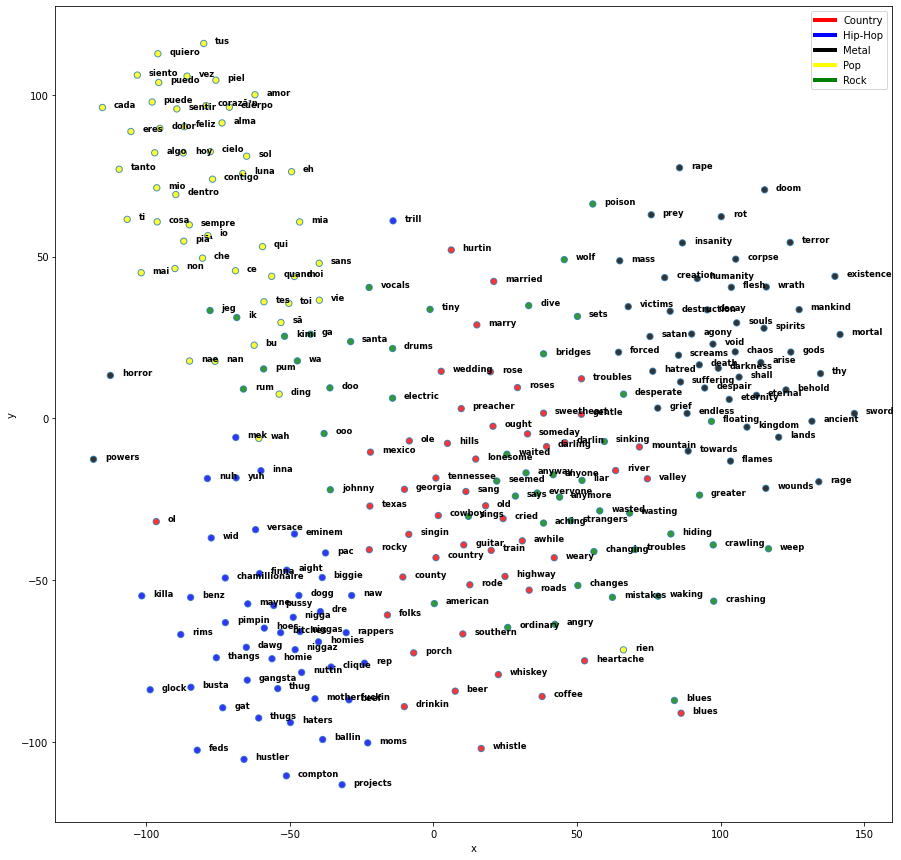

In [14]:
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color=color, lw=4) for color in colors_dict.values()]

fig, _ = plt.subplots()
fig.set_size_inches(15, 15)

p1 = sns.regplot(data=ganre_df,
                x="x",
                y="y",
                fit_reg=False,
                marker="o",
                scatter_kws={'s': 40,
                              'facecolors': ganre_df['color']
                            }
                )

for row in ganre_df.itertuples():
  plt.text(row[3] +4, row[4], row[1], horizontalalignment='left', size='small', color='black', weight='semibold')
plt.legend(custom_lines,colors_dict.keys())
plt.show()

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['clean_lyrics'], df['genre'], test_size=0.33, random_state=42)

model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(X_train, y_train)
predicted_categories = model.predict(X_test)

Show the confusion matrix.

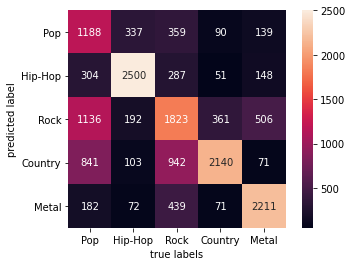

The accuracy is 0.5979506457284909


In [16]:
# plot the confusion matrix
labels = df['genre'].unique()
mat = confusion_matrix(y_test, predicted_categories, labels)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.yticks(rotation=0)
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
print("The accuracy is {}".format(accuracy_score(y_test, predicted_categories)))


Show the classification report - precision, recall, f1 for each class.

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_categories,target_names=labels))

              precision    recall  f1-score   support

         Pop       0.52      0.79      0.63      2713
     Hip-Hop       0.76      0.78      0.77      3204
        Rock       0.74      0.72      0.73      3075
     Country       0.56      0.33      0.41      3651
       Metal       0.45      0.47      0.46      3850

    accuracy                           0.60     16493
   macro avg       0.61      0.62      0.60     16493
weighted avg       0.60      0.60      0.59     16493



### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [18]:
def get_avg_vec(text):
  vec_list = []
  words = text.split()
  for word in words:
    try:
      vec_list.append(w2v_model.wv.get_vector(word))
    except:
      continue
  return   np.mean(vec_list,axis=0)

df['avg_vec'] = df.apply(lambda x: get_avg_vec(x['clean_lyrics']),axis=1) 
df['avg_vec'].head()

0    [-0.25389954, -0.08514764, -0.20556004, -0.066...
1    [-0.40568542, -0.39981994, -0.29856548, 0.2116...
2    [0.099167004, -0.11744166, -0.2387536, -0.1951...
3    [-0.07842293, -0.24766974, -0.2945381, -0.4112...
4    [-0.17937186, -0.14173925, -0.13446811, -0.362...
Name: avg_vec, dtype: object

In [19]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(df['avg_vec'].apply(pd.Series), df['genre'], test_size=0.33, random_state=42)

# model = XGBClassifier()
model = RandomForestClassifier()

model.fit(X_train,y_train)
predicted_categories = model.predict(X_test)

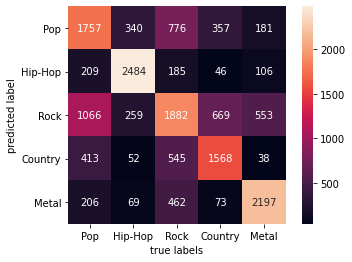

The accuracy is 0.5995270720911902


In [21]:
# plot the confusion matrix
labels = df['genre'].unique()
mat = confusion_matrix(y_test, predicted_categories, labels)

sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels, yticklabels=labels)
plt.yticks(rotation=0)
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
print("The accuracy is {}".format(accuracy_score(y_test, predicted_categories)))

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_lyrics'])
shared_words = set(word for word in w2v_model.wv.vocab.keys()).intersection(set(vectorizer.get_feature_names()))
missing_words = set(vectorizer.get_feature_names()) - shared_words
missing_words

In [31]:
vectorizer = TfidfVectorizer(stop_words=missing_words)
X = vectorizer.fit_transform(df['clean_lyrics'])

In [51]:
vectors = np.array([w2v_model.wv.get_vector(word) for word in vectorizer.get_feature_names()])
print(vectors.shape)
print(X.shape)

(18028, 300)
(49976, 18028)


In [55]:
X = X.dot(vectors)

In [58]:
X.shape

(49976, 300)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, df['genre'], test_size=0.33, random_state=42)

model = RandomForestClassifier()

model.fit(X_train,y_train)
predicted_categories = model.predict(X_test)

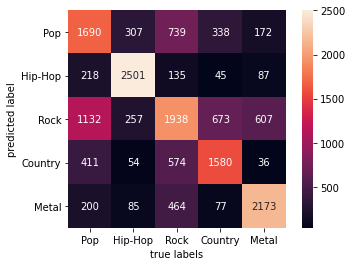

The accuracy is 0.5991632813921057


In [57]:
# plot the confusion matrix
labels = df['genre'].unique()
mat = confusion_matrix(y_test, predicted_categories, labels)

sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels, yticklabels=labels)
plt.yticks(rotation=0)
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
print("The accuracy is {}".format(accuracy_score(y_test, predicted_categories)))

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

In [10]:
import numpy as np
import pandas as pd
import torch
import os
if not os.path.exists('Embeddings'):
  os.mkdir('Embeddings')
  for ganre in df['genre'].unique():
    os.mkdir(f'Embeddings/{ganre}')

def get_songs_vectors(row):

  text = row['clean_lyrics']
  genre = row['genre']
  song = row['song']
  if row.name % 1000 ==0 and row.name !=0:
    print(f'{row.name} files was calculated...')

  song_vec = []
  countr = 0
  for word in text.split(): 
    try:
      song_vec.append(w2v_model.wv.get_vector(word))
      countr+=1
      if countr==128:
        break
    except:
      continue
  song_vec = np.array(song_vec)

  if song_vec.shape[0]<128:
    song_vec = np.concatenate([song_vec,np.zeros(((128-song_vec.shape[0]),300))])

  torch.save(torch.tensor(song_vec), f'Embeddings//{genre}//{song}.pt')
    
  # return song_vec

df.apply(lambda x: get_songs_vectors(x),axis=1)

1000 files was calculated...
2000 files was calculated...
3000 files was calculated...
4000 files was calculated...
5000 files was calculated...
6000 files was calculated...
7000 files was calculated...
8000 files was calculated...
9000 files was calculated...
10000 files was calculated...
11000 files was calculated...
12000 files was calculated...
13000 files was calculated...
14000 files was calculated...
15000 files was calculated...
16000 files was calculated...
17000 files was calculated...
18000 files was calculated...
19000 files was calculated...
20000 files was calculated...
21000 files was calculated...
22000 files was calculated...
23000 files was calculated...
24000 files was calculated...
25000 files was calculated...
26000 files was calculated...
27000 files was calculated...
28000 files was calculated...
29000 files was calculated...
30000 files was calculated...
31000 files was calculated...
32000 files was calculated...
33000 files was calculated...
34000 files was cal

0        None
1        None
2        None
3        None
4        None
         ... 
49971    None
49972    None
49973    None
49974    None
49975    None
Length: 49976, dtype: object

In [11]:
from torch import nn
import torch.nn.functional as F

class Network_batch(nn.Module):
    def __init__(self):
        super(Network_batch, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 1)      
        self.relu1 = nn.ReLU() 
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU() 
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,32,3,padding = 1)
        self.relu3 = nn.ReLU() 
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(16128, 120)
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout()
        self.fc3 = nn.Linear(84, 5)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = F.max_pool2d(x,2,2)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = F.max_pool2d(x,2,2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = F.avg_pool2d(x,2,2)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Network_batch()
net = net.to(device)
channels=1; H=300; W=128
from torchsummary import summary
summary(net, input_size=(channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 298, 126]             156
              ReLU-2          [-1, 6, 298, 126]               0
       BatchNorm2d-3          [-1, 6, 298, 126]              12
            Conv2d-4          [-1, 16, 145, 59]           2,416
              ReLU-5          [-1, 16, 145, 59]               0
       BatchNorm2d-6          [-1, 16, 145, 59]              32
            Conv2d-7           [-1, 32, 72, 29]           4,640
       BatchNorm2d-8           [-1, 32, 72, 29]              64
              ReLU-9           [-1, 32, 72, 29]               0
           Linear-10                  [-1, 120]       1,935,480
          Dropout-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
          Dropout-13                   [-1, 84]               0
           Linear-14                   

In [12]:
from torch.utils.data import Dataset, DataLoader

class LoadDataset(Dataset):
    def __init__(self, dataset_obj, label_mapping, transform=None):
        self.dataset = dataset_obj
        self.transform = transform
        self.label_mapping = label_mapping
          
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item_path = self.dataset[idx][0]
        item = torch.unsqueeze(torch.load(item_path),0)
        label = self.dataset[idx][1]
        sample = {'tensor': item, 'label': label_mapping[label]}
        if self.transform:
            sample = self.transform(sample)

        return sample

test_size = 0.2

train_set = []
test_set = []
label_mapping = {}
label_idx = 0
for label in os.listdir('./Embeddings'):
  label_mapping[label] = label_idx
  label_idx +=1
  for song in os.listdir(f'./Embeddings/{label}'):
    if np.random.random() > test_size:
      train_set.append((f'./Embeddings/{label}/{song}',label))
    else:
      test_set.append((f'./Embeddings/{label}/{song}',label))


train_loader = DataLoader(LoadDataset(train_set, label_mapping = label_mapping),shuffle = True, batch_size = 16)
test_loader = DataLoader(LoadDataset(test_set, label_mapping = label_mapping), shuffle = False, batch_size = 16)
train_size = len(train_set)
test_size = len(test_set)
train_size,test_size

(37063, 9286)

In [45]:
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
from datetime import datetime

n_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

best_accuracy = 0.0
best_epoch_predictions = []
best_model = copy.deepcopy(net.state_dict())

train_accuracies = []
test_accuracies = []
train_losses = []
test_losses  = []


for epoch in range(n_epochs):
    print(f"epoch {epoch+1} / {n_epochs}")
    start_time = datetime.now()
    net.train()
    running_loss = 0.0
    running_corrects = 0
    val_loss = 0.0
    val_corrects = 0
    with torch.set_grad_enabled(True):
        for idx,batch in enumerate(train_loader):
            inputs, labels = batch['tensor'].float(), batch['label']
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer_ft.zero_grad()
            outputs = net(inputs)
            _, preds = torch.max(outputs,1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_ft.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        exp_lr_scheduler.step()
    print(f"training loss: {running_loss / train_size} training accuracy: {running_corrects /  train_size} time:{(datetime.now() - start_time).total_seconds()} secs")
    train_accuracies.append(running_corrects /  train_size)
    train_losses.append(running_loss / train_size)
    net.eval()
    start_time = datetime.now()
    with torch.set_grad_enabled(False):
        test_preds = []
        for batch in test_loader:
            inputs,labels = batch['tensor'].float(), batch['label']
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, preds = torch.max(outputs,1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            test_preds.extend(preds)
        val_accuracy = val_corrects /  test_size
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_epoch_predictions = [i.item() for i in test_preds]
            best_model = copy.deepcopy(net.state_dict())
    print(f"val loss: {val_loss / test_size} val accuracy: {val_accuracy} time: {(datetime.now() - start_time).total_seconds()} secs")
    test_accuracies.append(val_accuracy)
    test_losses.append(val_loss / test_size)

epoch 1 / 10
training loss: 1.350711204012873 training accuracy: 0.41283759474754333 time:250.694088 secs
val loss: 1.2030214892875628 val accuracy: 0.5030152797698975 time: 72.114688 secs
epoch 2 / 10
training loss: 1.2511065709778428 training accuracy: 0.45573753118515015 time:290.92071 secs
val loss: 1.1466239498731214 val accuracy: 0.5121688842773438 time: 71.928705 secs
epoch 3 / 10
training loss: 1.2010103536431171 training accuracy: 0.47880634665489197 time:290.829451 secs
val loss: 1.1539899128253106 val accuracy: 0.5299375653266907 time: 71.969505 secs
epoch 4 / 10
training loss: 1.1505428549379004 training accuracy: 0.5149880051612854 time:289.233669 secs
val loss: 1.099693313770553 val accuracy: 0.5660133957862854 time: 71.390446 secs
epoch 5 / 10
training loss: 1.1179323755195631 training accuracy: 0.5336589217185974 time:290.336156 secs
val loss: 1.0675896699126106 val accuracy: 0.5748438835144043 time: 71.894058 secs
epoch 6 / 10
training loss: 1.0794616971908029 training

The accuracy is 0.5916433340512599


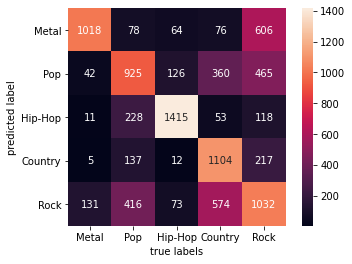

In [62]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

labels = test_loader.dataset.label_mapping
y_test = [label_mapping[i[1]] for i in test_loader.dataset.dataset]
y_pred = [i.item() for i in test_preds]


sns.heatmap(confusion_matrix(y_test, y_pred),xticklabels=labels,yticklabels=labels,square = True, annot=True,fmt = "d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.yticks(rotation=0);
print("The accuracy is {}".format(accuracy_score(y_test, y_pred)))